In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)

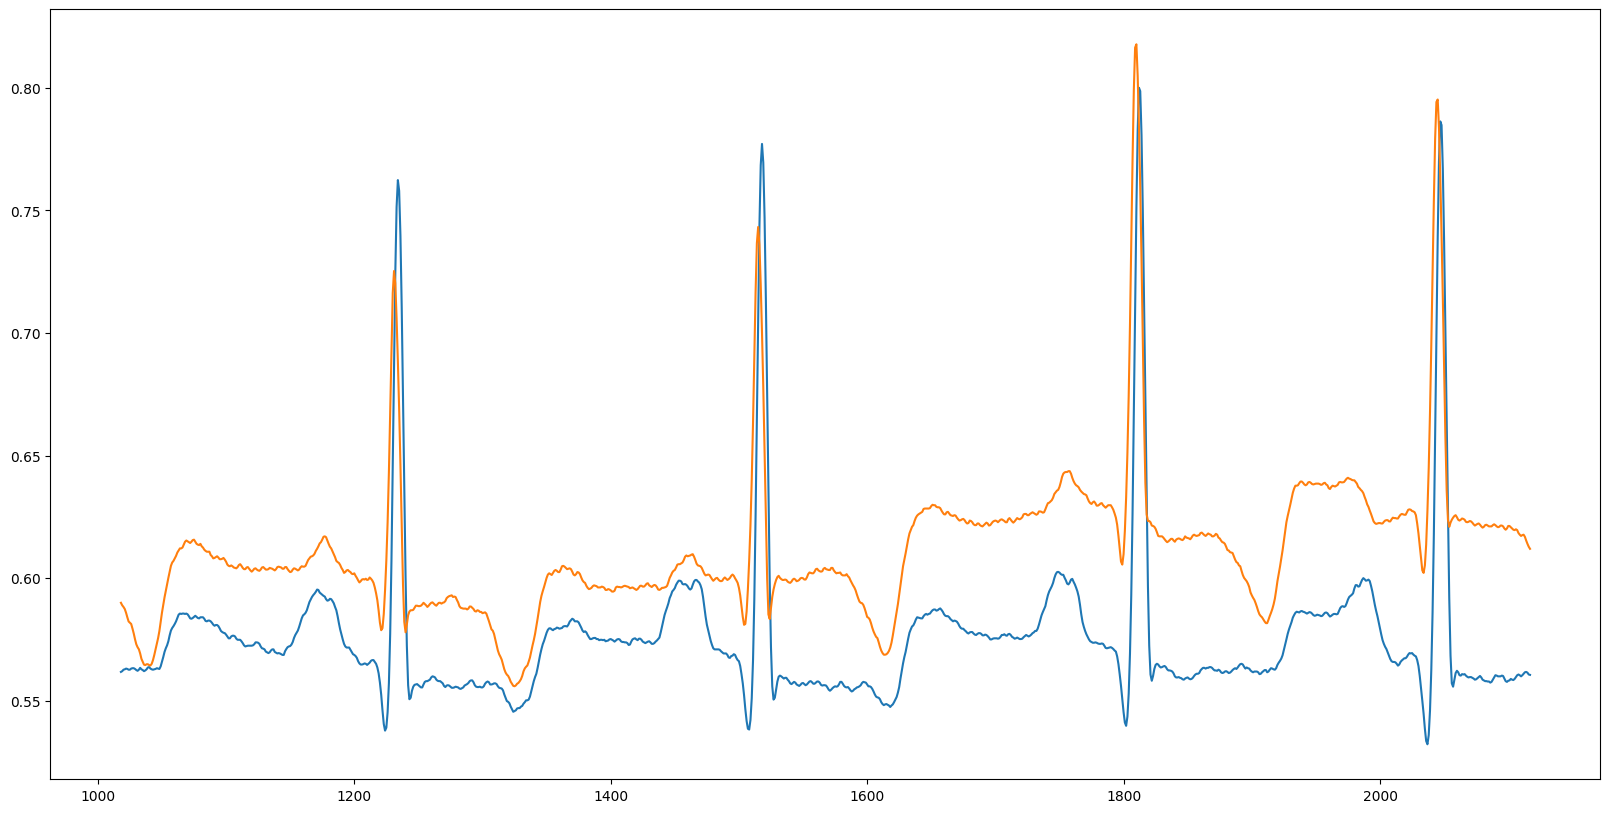

In [52]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')



# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

df.reset_index(drop=True, inplace=True)

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

In [53]:
beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for index, row in beat_df.iterrows():
    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])
    # Calculate mean and std values for MLII
    mean_value = df['MLII'][sample1:sample2].mean()
    std = df['MLII'][sample1:sample2].std()
    mean_list.append(mean_value)
    std_list.append(std)

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['MLII_mean'] = mean_list
beat_df['MLII_std'] = std_list

In [55]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        df_temp.columns = df_temp.columns[:-2].tolist() + ['Signal 1', 'Signal 2']
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

In [56]:
filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

df = filtered_data

# Based on the time of the annotations, fill the NaN values with the previous annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')

Sample #    31197531
Signal 1    31197531
Signal 2    31197531
Patient     31197531
Time          112646
Type        31197531
Sub           112646
Chan          112646
Num           112646
Aux             1728
dtype: int64


<BarContainer object of 10 artists>

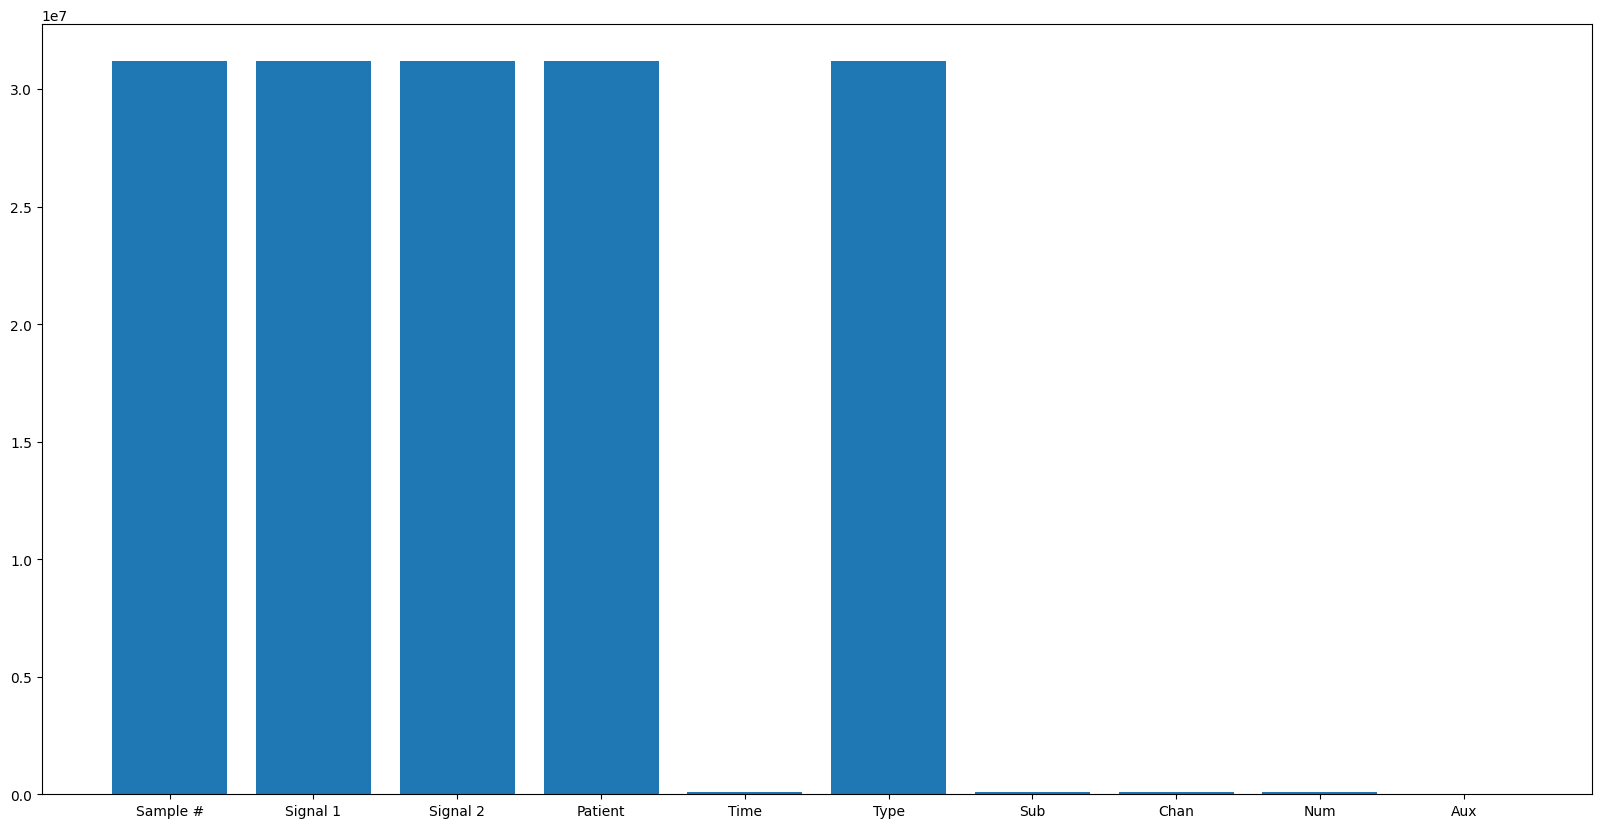

In [57]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [58]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
Signal 1      int64
Signal 2      int64
Patient      object
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [59]:
df.describe()

,Sample #,Signal 1,Signal 2,Sub,Chan,Num
count,3.119753e+07,3.119753e+07,3.119753e+07,112646.000000,112646.0,112646.0
mean,3.250252e+05,9.562826e+02,1.001037e+03,0.062603,0.0,0.0
std,1.876240e+05,9.447422e+01,8.981329e+01,0.406945,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.0,0.0
25%,1.625380e+05,9.070000e+02,9.510000e+02,0.000000,0.0,0.0
50%,3.250250e+05,9.650000e+02,1.019000e+03,0.000000,0.0,0.0
75%,4.875120e+05,9.950000e+02,1.047000e+03,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,2.047000e+03,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'Signal 1'}>],
       [<AxesSubplot: title={'center': 'Signal 2'}>,
        <AxesSubplot: title={'center': 'Sub'}>],
       [<AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

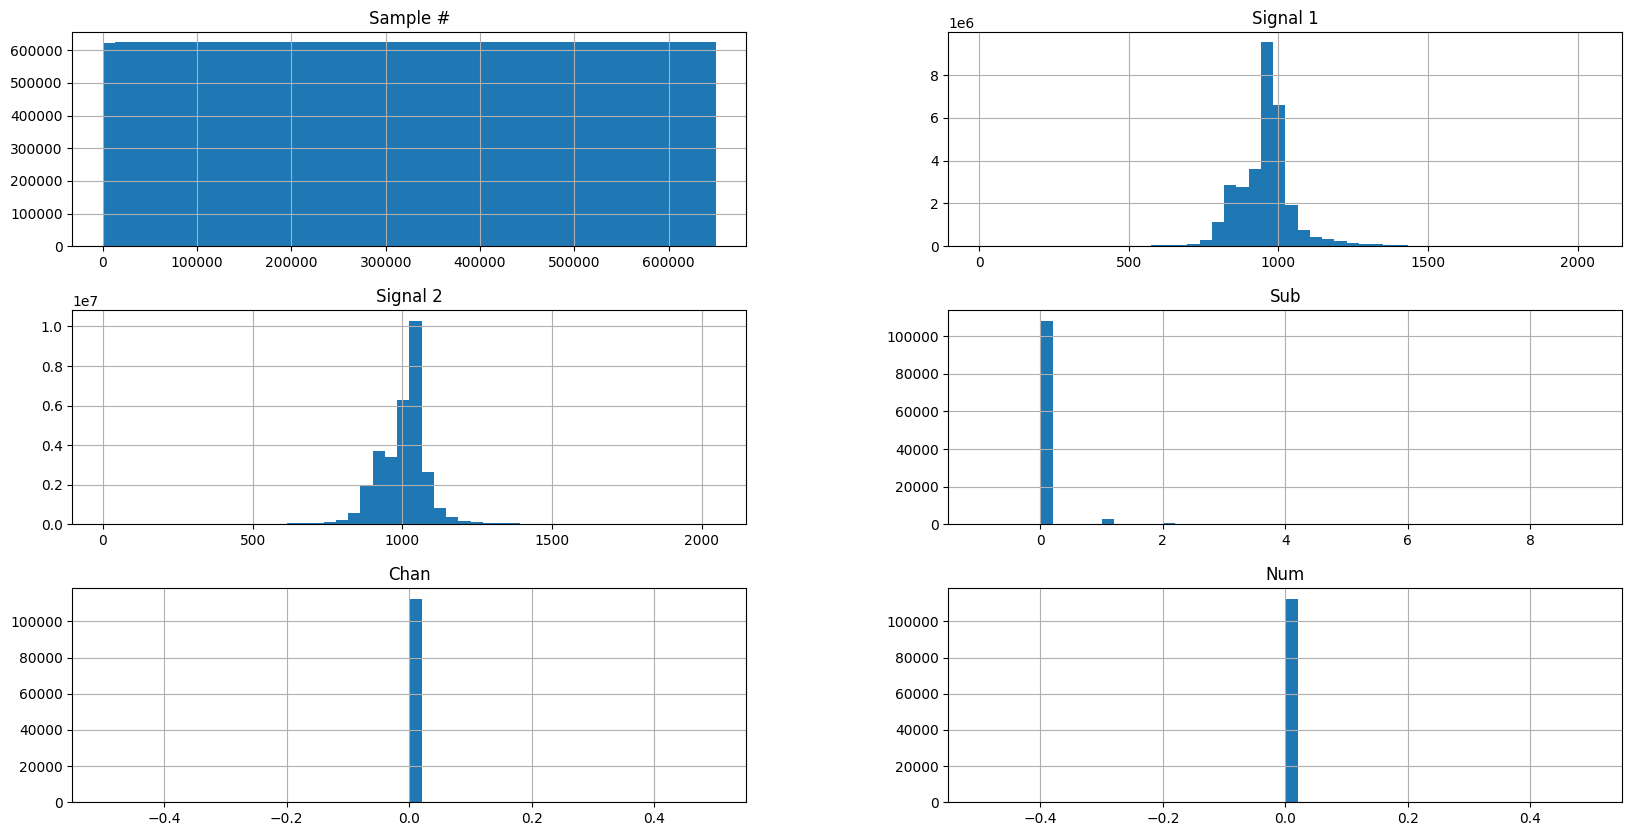

In [60]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

In [61]:
# Scaling MLII, V1, V2, V4 and V5
scaler = MinMaxScaler()
Signal1 = df['Signal 1'].to_numpy()
Signal2 = df['Signal 2'].to_numpy()

df['Signal 1'] = scaler.fit_transform(Signal1.reshape(-1, 1))
df['Signal 2'] = scaler.fit_transform(Signal2.reshape(-1, 1))

In [62]:
# Filtering MLII, V1, V2, V4 and V5 with moving average
df['Signal 1'] = df['Signal 1'].rolling(window=8, min_periods=1).mean()
df['Signal 2'] = df['Signal 2'].rolling(window=8, min_periods=1).mean()

In [63]:
# Create beat_df DataFrame
beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True),
    'Type': df_copy['Type'][0:-1].reset_index(drop=True),
    'Patient': df_copy['Patient'][0:-1].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list1 = []
std_list1 = []
mean_list2 = []
std_list2 = []
patient_list = []
type_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for patient_id in df['Patient'].unique():
    print(patient_id)
    for index, row in beat_df.loc[df_copy['Patient'] == patient_id].iterrows():
        sample1 = int(row['sample1'])
        sample2 = int(row['sample2'])

        # Calculate mean and std values for Signal 1
        mean_value = df['Signal 1'][sample1:sample2].mean()
        std = df['Signal 1'][sample1:sample2].std()
        mean_list1.append(mean_value)
        std_list1.append(std)

        # Calculate mean and std values for Signal 2
        mean_value = df['Signal 2'][sample1:sample2].mean()
        std = df['Signal 2'][sample1:sample2].std()
        mean_list2.append(mean_value)
        std_list2.append(std)

        patient_list.append(patient_id)
        type_list.append(df_copy['Type'][index])

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['Signal 1 mean'] = mean_list1
beat_df['Signal 1 std'] = std_list1
beat_df['Signal 2 mean'] = mean_list2
beat_df['Signal 2 std'] = std_list2
beat_df['Patient'] = patient_list
beat_df['Type'] = type_list

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


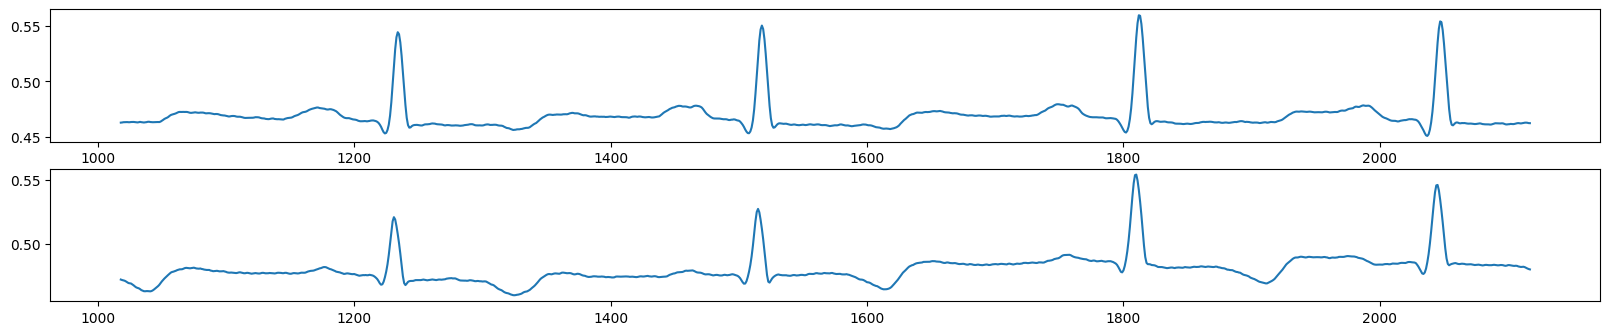

In [64]:
# Plot ecg examples with each feature in its subplot
plt.figure(figsize=(20, 10))
plt.subplot(511)
plt.plot(df['Sample #'][1000:2100], df['Signal 1'][1000:2100])
plt.subplot(512)
plt.plot(df['Sample #'][1000:2100], df['Signal 2'][1000:2100])

In [65]:
beat_df.head()

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 2 mean,Signal 2 std,Patient,Type
0,18,77,0,0.163889,0.480682,0.024167,0.492107,0.014794,100,+
1,77,370,1,0.813889,0.472503,0.014797,0.480649,0.008468,100,N
2,370,662,2,0.811111,0.467612,0.013643,0.478322,0.011205,100,N
3,662,946,3,0.788889,0.466460,0.013268,0.477504,0.010972,100,N
4,946,1231,4,0.791667,0.468437,0.011810,0.476630,0.007494,100,N


In [66]:
# Group beats with 'Type' value of N, L, R, e and j into the N category
beat_df['Type'].replace(to_replace=['N', 'L', 'R', 'e', 'j'], value='N', inplace=True)

# Group beats with 'Type' value of A, a, J, S into the S category
beat_df['Type'].replace(to_replace=['A', 'a', 'J', 'S'], value='S', inplace=True)

# Group beats with 'Type' value of V, E into the V category
beat_df['Type'].replace(to_replace=['V', 'E'], value='V', inplace=True)

# Group beats with 'Type' value not above (except F) into the Q category
beat_df['Type'].replace(to_replace=['/', 'f', 'Q'], value='Q', inplace=True)

# Eliminate entries with ~, +, x, [, ], !, " and | in 'Type' column
beat_df = beat_df[beat_df['Type'] != '~']
beat_df = beat_df[beat_df['Type'] != '+']
beat_df = beat_df[beat_df['Type'] != 'x']
beat_df = beat_df[beat_df['Type'] != '[']
beat_df = beat_df[beat_df['Type'] != ']']
beat_df = beat_df[beat_df['Type'] != '!']
beat_df = beat_df[beat_df['Type'] != '"']
beat_df = beat_df[beat_df['Type'] != '|']

In [67]:
# Count how many times each Type value appears in the dataset
print(beat_df['Type'].value_counts())

N    90630
Q     8043
V     7236
S     2781
F      803
Name: Type, dtype: int64


In [72]:
# Identify the majority class by finding the class with the most samples
majority_class = beat_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = beat_df[beat_df['Type'] == majority_class]
minority_class_data = beat_df[beat_df['Type'] != majority_class]

# Determine the number of samples you want to keep for the majority class
# You can set this number based on the number of samples in the minority class
undersampled_majority = resample(majority_class_data,
                                 replace=False,  # Set to False for undersampling
                                 n_samples=len(minority_class_data), 
                                 random_state=42)  # Use a fixed random state for reproducibility

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([undersampled_majority, minority_class_data])

# Optionally, you can shuffle the dataset
undersampled_data = undersampled_data.sample(frac=1, random_state=42)

# Check the counts for each class
print(undersampled_data['Type'].value_counts())

N    18863
Q     8043
V     7236
S     2781
F      803
Name: Type, dtype: int64


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

# Load your dataset (assuming you have it in a DataFrame)
# Replace 'target_column' with the actual name of your target variable column
# Replace other_column_names with the names of your input features
target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 2 mean', 'Signal 2 std']

# Encode the target variable into numerical values
le = LabelEncoder()
beat_df[target_column] = le.fit_transform(beat_df[target_column])

# Shuffle the dataset (optional but recommended)
beat_df = shuffle(beat_df)

# Define the number of cross-validation folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores
cv_scores = []

# Define the architecture of the deep neural network
def create_model(input_dim, num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(beat_df[other_column_names], beat_df[target_column]):
    X_train, X_test = beat_df[other_column_names].iloc[train_index], beat_df[other_column_names].iloc[test_index]
    y_train, y_test = beat_df[target_column].iloc[train_index], beat_df[target_column].iloc[test_index]

    # Create and compile the model
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = create_model(input_dim, num_classes)

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    cv_scores.append(fold_accuracy)

# Calculate the mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_accuracy:.2f}")
